# Introduction to Natural Language Processing 2 Lab04

**This lab is mainly about data and model analysis. There is very little code. Make sure you send back a proper report with your code, guideline, annotated sheets, and theoretical answers.**

In [1]:
!pip install -q datasets bertopic shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━

## Introduction (1 point)

Your company wants to sell a moderation API tackling toxic content on Twitter. They ask you to come up with a model which detect toxic tweets. You remember your NLP classes, and start looking for existing models or datasets, and find a collection of [academic Twitter dataset on HuggingFace hub](https://huggingface.co/datasets/tweet_eval). Especially, the `hate` and `offensive` datasets seem close to what you are looking for.

1. (1 point) Pick one of the datasets between `hate` and `offensive`, and justify your choice. Remember that it is for a commercial application (there is a good and a bad answer).

We chose the offense dataset for commercial use, because the hate dataset cannot be utilized as per the license restrictions. We need to seek permission before using it.

## Evaluating the dataset (5 points)

Before using the data to train a model, you have the right reflex and start with a data analysis.

1. (1 point) Describe the dataset. Look at the splits, proportion of classes, and see what you can figure out by just looking at the text.

In [2]:
from datasets import load_dataset
from datasets import Dataset
import pandas as pd
import numpy as np

In [3]:
dataset_train = load_dataset("tweet_eval", "offensive", split="train")
dataset_val = load_dataset("tweet_eval","offensive", split="validation")
dataset_test = load_dataset("tweet_eval","offensive", split="test")

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/11916 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/860 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1324 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to /root/.cache/huggingface/datasets/tweet_eval/offensive/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.


The dataset is composed of:

- train: 11900 samples (90%)
- validation: 1320 samples (10%)
- test: 860 rows

The proportion of the validation is small compared to the training dataset, but it's still manageable to have 10 percent validation.

In [4]:
def proportions(name, ds):
    t_0 = ((np.array(ds["label"]) == 0).sum() / len(ds["label"]))
    t_1 = 1.0 - t_0
    print(f"{name} has {t_0:0.2f} of non offensive (0) and {t_1:0.2f} of offensive (1)")

proportions("Train", dataset_train)
proportions("Validation", dataset_val)
proportions("Test", dataset_test)

Train has 0.67 of non offensive (0) and 0.33 of offensive (1)
Validation has 0.65 of non offensive (0) and 0.35 of offensive (1)
Test has 0.72 of non offensive (0) and 0.28 of offensive (1)


In [5]:
dataset_train[0]["text"]

'@user Bono... who cares. Soon people will understand that they gain nothing from following a phony celebrity. Become a Leader of your people instead or help and support your fellow countrymen.'

The first word of sentences are most often a twitter username "@user", which can be the person the tweet's writer is replying to. This means most of the tweets are replies. Mentions of other users are replaced by "@user", which means the tweets are also anonymized.

2. (3 points) Use [BERTopic](https://github.com/MaartenGr/BERTopic) to extract the topics within the data, and the main topics within each class. Please, think about [fixing the random seed](https://stackoverflow.com/questions/71320201/how-to-fix-random-seed-for-bertopic).
    * A [good model](https://github.com/MaartenGr/BERTopic#embedding-models) for sentence similarity is `all-MiniLM-L6-v2`, as it is [fast, light, and pretty accurate](https://www.sbert.net/docs/pretrained_models.html). You can use another one, but make sure to document your choice.
    * [This](https://maartengr.github.io/BERTopic/api/plotting/topics_per_class.html) might help.

In [6]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from plotly.graph_objects import Figure

# Random seed can't be fixed as the same way as the stackoverflow

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic(embedding_model=sentence_model)

In [7]:
def extract_topics(topic_model : BERTopic, dataset : Dataset) -> Figure:
    """
    Extract topics using BERTopic model and visualize topics per class.

    Args:
        topic_model (BERTopic): BERTopic model for topic extraction.
        dataset (Dataset): Dataset containing text and label columns.

    Returns:
        Figure: Plotly figure object displaying the topics per class visualization.
    """
    topics, probs = topic_model.fit_transform(dataset["text"])
    topics_per_class = topic_model.topics_per_class(dataset["text"], classes=dataset["label"])
    return topic_model.visualize_topics_per_class(topics_per_class, normalize_frequency=True, width=700, height=400)

In [8]:
extract_topics(topic_model, dataset_train)

In [9]:
extract_topics(topic_model, dataset_val)

In [10]:
extract_topics(topic_model, dataset_test)

3. (1 point) What do you think about the results? How do you think it could impact a model trained on these data?

The topic analysis identified similarities, such as the topic of "gun control," between the train and test datasets. However, notable differences were observed, as the topic "07_fuck_shit_ass_fucking" did not appear in the test dataset.

The topic analysis reveals different frequencies and distributions of topics between the two classes. The importance of topics and the presence of different topics vary, which might pose challenges for the model's generalization if it encounters unseen topics. It's noteworthy that most of the categories are about politics.

4. **Bonus** By default, BERTopic extracts single keywords. Play with the model to extract bigrams or more. See if you can go deeper in your analysis.

In [11]:
topic_model_ngrams = BERTopic(n_gram_range=(2, 4))

In [12]:
extract_topics(topic_model_ngrams, dataset_train)

In [13]:
extract_topics(topic_model_ngrams, dataset_val)

In [14]:
extract_topics(topic_model_ngrams, dataset_test)

Using higher n-gram representation for topics leads to having more complex topics that are composed of multiple words. We can observe that we mostly find the word "user" in the topics due to the fact that the dataset was anonymized and all usernames were replaced by "user". Other topics like "07_fuck_shit_ass_fucking" completely disappear. The topics are mainly influenced by hashtags.

## Evaluate a model (8 points)

You were thinking about fine-tuning a [RoBERTa](https://arxiv.org/abs/1907.11692) model on the dataset, but RoBERTa has been train on 2019 data, which do not include any tweet. Moreover, pretraining a model from scratch can be costly. Fortunately, a [reliable entity](https://github.com/cardiffnlp) pretrained RoBERTa on recent tweets and even fine-tuned it on both datasets [here](https://huggingface.co/cardiffnlp/twitter-roberta-base-offensive?text=I+like+you.+I+love+you) and [here](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate?text=I+like+you.+I+love+you).

1. (2 points) Evaluate their model on the test split of the dataset you picked, using precision, recall, and F1-score.

In [15]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report
from typing import List, Dict

In [16]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-offensive")

In [17]:
nlp_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [18]:
preds = nlp_pipeline(dataset_test["text"])

In [19]:
def evaluate_classification_performance(dataset : Dataset, preds : Dict) -> None:
    """
    Evaluate the performance of the classification model on the dataset.

    Args:
        dataset (Dataset): Dataset containing text and label columns.
        pres (Dict): Predictions of the dataset.

    Returns:
        None
    """

    label2int = lambda pred: 1 if pred["label"] == 'offensive' else 0
    int_preds = list(map(label2int, preds))

    print(classification_report(dataset["label"], int_preds))


In [20]:
evaluate_classification_performance(dataset_test, preds)

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       620
           1       0.80      0.67      0.73       240

    accuracy                           0.86       860
   macro avg       0.84      0.80      0.82       860
weighted avg       0.86      0.86      0.86       860



2. (2 points) Look for prediction failures. Extract the top 5 misclassified tweets (highest score in wrong class) for each class and discuss what could be wrong with the model.

In [21]:
import pandas as pd

preds_df = pd.DataFrame(preds)

In [22]:
def top5_missclassified(dataset : Dataset, preds_df: pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Extract the top 5 missclassified tweets with the highest score in the wrong class.

    Args:
        preds_df (pd.DataFrame): DataFrame containing prediction scores and labels.
        label (str): True label of the misclassified tweets.

    Returns:
        pd.DataFrame: DataFrame with the top 5 misclassified tweets for the specified label.
    """
    # Merge dataset and result
    df = dataset_test.to_pandas().join(preds_df, rsuffix="_preds")
    df["label_preds"] = df["label_preds"].apply(lambda label: 1 if label == 'offensive' else 0)

    # return preds_df[preds_df["label"] != label].sort_values(by="score", ascending=False)[:5]
    label2int = 1 if label == "offensive" else 0
    return df[(df["label_preds"] == label2int) & (df["label"] != df["label_preds"])].sort_values(by="score", ascending=False)[:5]["text"]

In [23]:
# Badly classified was classified offensive but was non-offensive
top5_missclassified(dataset_test, preds_df, "offensive")

524                             Are you fucking serious?
455      @user I guess that’s where swamp ass originated
521    An American Tail really is one of the most und...
728    @user @user Bull crap. You know she doesn't ca...
569    #Room25 is actually incredible, Noname is the ...
Name: text, dtype: object

In [24]:
# Badly classified was classified non-offensive but was offensive
top5_missclassified(dataset_test, preds_df, "non-offensive")

96     #Liberals / #Democrats THIS is what you stand ...
177    #Liberals Are Reaching Peak Desperation To Cal...
418    #NoPasaran: Unity demo to oppose the far-right...
228    #BREXIT deal HAS been reached - and will be un...
122    #America  ... tear down that #Wall! #tcot #par...
Name: text, dtype: object

The model could have difficulties handling different aspects:


- They are related to complex topics and almost all start with a hashtag that is related to current news.
- They appear to be responses that are addressed to someone.
- A question can also be difficult to interpret

To see how the model would fare on production data, you have 10K English tweets and replies available on the tweets.json file (taken from [internet archive](https://archive.org/details/archiveteam-twitter-stream-2021-07)). Note that the language was filtered using the Twitter API, so there might still be tweets in more than just English. The JSON fields were trimmed to minimum and the text was already preprocessed to mask user handles and URLs, like the tweets in your dataset.

3. (2 points) Extract the top 10 tweets your model is most confident about in the target class (offensive or hateful), the top 10 in the neutral class, and the top 10 your model is most uncertain about. Do you believe the model is doing a great job?

In [25]:
def extract_top10(preds_df : pd.DataFrame, label: str) -> pd.DataFrame:
    """
    Extract the top 10 most confident predictions of a class.

    Args:
        preds_df (pd.DataFrame): DataFrame containing prediction scores and labels.

    Returns:
        pd.DataFrame: DataFrame with the top 10 most confident predictions of label tweets.
    """
    return preds_df[preds_df["label"] == label].sort_values(by="score", ascending=False)[:10].index

In [26]:
# Top 10 confidence offensive tweet
for index, text in enumerate(dataset_test[extract_top10(preds_df, "offensive")]["text"]):
    print(f"Example {index + 1}: {text}")

Example 1: @user nigga are you stupid your trash dont play with him play with your bitch 😂
Example 2: #ArianaAsesina? Is that serious?! Holy shit, please your fucking assholes, don't blame someone for the death of other one. She is sad enough for today, don't you see? It isn't fault of none, he had an overdose and died. End. Stop wanting someone to blame, fuckers.
Example 3: @user Damn I felt this shit. Why you so loud lol
Example 4: $1500 for a phone. You all are fucking dumb.
Example 5: All these sick ass ppl from school gave me something and now I have to chug down this nasty drink so it can go away🙃
Example 6: #SugarDaddy Retweet if you are under 30 and would like share memes with each other and we can talk about dumb shit. Cuz baby I’m broke as shit but this love rich
Example 7: #OrrinHatch I can’t believe this sexist , clueless, old fart gets to weigh in on another woman’s charges against a Supreme Court nominee. And he is spouting the same old nasty shit he spewed 20+ years ago 

In [27]:
# Top 10 confidence non-offensive tweet
for index, text in enumerate(dataset_test[extract_top10(preds_df, "non-offensive")]["text"]):
    print(f"Example {index + 1}: {text}")

Example 1: #WCW #WCE @user  It’s your special day of the week again. I really miss you and I’m looking forward to see you soon. Don’t forget that I love you. I love you with all my heart because you are my heart! ❤️
Example 2: #WELOVESEUNGCHEOL @user   I am happy and proud of the work you have done to train seventeen along with the other members. I see you and you are wonderful and incredible. I really love u ㅠㅠ 💕.
Example 3: #NationalDayofEncouragement  #TwitterFamily  You’re amazing just the way you are 💟☮️
Example 4: #AskAlly I only say that I adore you and you are a great person, please take care of yourself always❤️
Example 5: #WeLoveSergioBecause he is the sweetest guy ever! He loves us so much and I'm so happy to be his fan!
Example 6: #TheLadyBam has spoken! ❤ She is simply the BEST! 🙏🏼 #SpreadMaryLove 👠💃 #Onward
Example 7: #WCW to @user   I mean hey, she is a great friend and I am more than happy to help with missions and anything else she might need!
Example 8: @user @user Sh

In [28]:
def most_uncertain(preds_df : pd.DataFrame):
    """
    Extract the top 10 most uncertain predictions

    Args:
        preds_df (pd.DataFrame): DataFrame containing prediction scores and labels.

    Returns:
        pd.DataFrame: DataFrame with the top 10 most uncertain predicitions.
    """
    return (preds_df["score"] - 0.5).sort_values()[:10].index

In [29]:
for index, text in enumerate(dataset_test[most_uncertain(preds_df)]["text"]):
    print(f"Example {index + 1}: {text}")

Example 1: @user @user @user @user @user @user Really? The GOP hasn't even seen the letter yet. This sham is as subtle as a banana on a pool table and you won't, cant, see it. DiFi throws a hail Mary @ the 13th hour,  and you cry foul. At elast Ford won't have antifa coming to burn her house down. Dems are going down, hard.
Example 2: #RAP is a form of ART! Used to express yourself freely. It does not gv the green light or excuse the behavior of acting like an animal! She is not in the streets of the BX where violence is a way of living. Elevate yourself boo and get on @user level for longevity! #QUEEN👑
Example 3: #Democrats..2) we have yet to hear one of these righteous Democrats 'attack and insist' that Ellison resign after 'he' was accused of assault nor have we heard them call for Cory 'Spartacus' Booker to resign after he 'admitted' to sexual assault in 1992..the 'stink' of liberals.
Example 4: #Conservatives have no genetic ability to understand #hypocrisy or #irony. Right wing i

The model performs remarkably well. It appears to excel on tweets with hashtags and emojis that clearly express their intention. However, for uncertain examples, it seems that they are mostly related to politics, which is a complex and controversial topic. It is reasonable to assume that political topics can provoke both offensive and non-offensive expressions, hence they are represented in both classes. It also seems that classifying responses to other users is sometimes challenging, likely because the model would benefit from more contextual information.

4. **Bonus** Use [SHAP](https://github.com/slundberg/shap/tree/45b85c1837283fdaeed7440ec6365a886af4a333#natural-language-example-transformers) on the provided tweets, or manually written texts, to see if you can find topics on which the model is biased.

In [53]:
import shap

explainer = shap.Explainer(nlp_pipeline)
shap_values = explainer(["We be going to fuck him up."])
shap.plots.text(shap_values[0, :, "offensive"])

  0%|          | 0/90 [00:00<?, ?it/s]


Partition explainer: 2it [00:37, 37.17s/it]               


In [54]:
shap_values = explainer(["We are going to fuck him up."])
shap.plots.text(shap_values[0, :, "offensive"])

  0%|          | 0/156 [00:00<?, ?it/s]


Partition explainer: 2it [00:37, 37.34s/it]               


The partition example shows that when using African American Vernacular English, it is considered slightly more offensive than standard English. This demonstrates a bias towards this dialect.

5. **Bonus** Train a naive Bayes model on the data, and compare its results with this model.

In [31]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeline = make_pipeline(
    CountVectorizer(),
    MultinomialNB()
)

In [32]:
X_train, y_train = dataset_train['text'], dataset_train['label']
X_test, y_test = dataset_test['text'], dataset_test['label']

In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [34]:
y_preds = pipeline.predict(X_test)

In [35]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       620
           1       0.62      0.56      0.59       240

    accuracy                           0.78       860
   macro avg       0.73      0.71      0.72       860
weighted avg       0.78      0.78      0.78       860



If we compare both models, we can see that the RoBERTa model performs well overall, especially in terms of precision for the target class. However, if we compare them in terms of time complexity, the Naive Bayes model is clearly faster and achieves acceptable performance, considering that it doesn't take into account the relationship between words and sentences.

## Annotate data (7 points)

Regardless of the model's performances, you decide to annotate your own collection of tweets.

1. (1 point) Extract about 100 tweets containing at least 20% of your target class (offensive/hateful), from the 10K tweets provided. You can use the pretrained model to help you find tweets in the target class.

In [68]:
def extract_100_tweets(file_path : str):
  """
      Extract 100 tweets and predict if they are offensive

      Args:
        file_path (String): file_path of the tweets

      Returns:
        predictions for the 100 sample of the file_path
  """

  # Read the JSON file into a DataFrame
  data = pd.read_json(file_path)

  data_sub = data.iloc[0:200]
  data_pred = nlp_pipeline(list(data_sub["text"]))

  data_pred_df = pd.DataFrame(data_pred)
  data_pred_df = pd.concat([data_sub, data_pred_df], axis=1)[["text", "label", "score"]]

  print(data_pred_df.value_counts("label"))

  data_offensive = data_pred_df[data_pred_df["label"] == "offensive"]
  data_non_offensive = data_pred_df[data_pred_df["label"] == "non-offensive"]
  data_concats = pd.concat([data_offensive.head(26), data_non_offensive.head(100-26)])
  data_concats = data_concats[["text", "label"]]
  data_concats.value_counts("label")

  df_copy = data_concats.copy()

  data_concats["label"] = data_concats["label"].replace({"offensive": 0, "non-offensive": 0})

  data_concats.to_csv("tweets_100.csv", index=False)

  return df_copy

In [69]:
tweets_preds = extract_100_tweets("tweets.json")

label
non-offensive    174
offensive         26
dtype: int64


2. (3 points) Altogether, write down an annotation guildeline (which should be at least 2/3 of a page long).
    * What does the target class look like?
    * Any examples you could provide for ambiguous cases?
    * Keep "Can't tell / not annotable" class. Make sure you document what this class mean in your guideline.

***
# Annotation Guideline for Labeling Tweets as Offensive

## Introduction
The purpose of this guideline is to assist annotators in classifying tweets into three categories: `Offensive`, `unoffensive`, and `not annotatable`.

## Target Class: Offensive
Tweets that fall under the "Offensive" class contain language, imagery, or content that is:
- derogatory
- harmful
- threatening
- disrespectful

towards individuals or groups based on characteristics **such as race, gender, religion, sexual orientation, or any other defining trait.**

### Characteristics of Offensive Tweets:
Firstly, we start by characterizing offensive tweets and giving examples for each point."

- **Use of slurs, derogatory terms, or profanity.**

Example: You're nothing but a *whore*.

- **Hate speech targeting specific groups racism**.

Example: All people from [group] are *dumb*.

- **Threatening language or incitement of violence.**

Example: We should *kill* this guy.
    
- **Contains explicit content.** (for example lyrics)

Example: "Sell crack to your Auntie Denise/If Auntie Denise is short 40 cent/Make her get on the ground and suck your small dick" - Bizarre

- **Harassment or bullying of other people or a group of members.**

Example: You are always wrong, *nobody likes you*, just leave us alone.

- **Discriminatory language or content.**

Example: I don't want to work with people from *[group or person]*, they are always lazy.

## Ambiguous Cases
Sometimes, it's difficult to clearly say if a tweet is offensive or not because of how it's written or used.

#### Example 1:
Phrase: "That's gay." Depends of the context of the
- If used derogatorily to imply something negative, it's offensive.
- If used within the LGBTQ+ community as a term of empowerment, it may not be offensive.
- If used to describe something factually related to gay culture, it’s neutral.

#### Example 2:
Phrase: “You’re the bomb!” depends also fron the context it's used:
- If used to compliment someone (e.g., "You’re amazing!"), it's not offensive.
- If used in a threatening context implying violence, it's offensive.

### Can't Tell/Not Annotatable Class
If a tweet lacks sufficient context to determine its meaning, it should be categorized as "not annotable." That's why we have a special category called "not annotable" for situations like these.

### Criteria for Can't Tell/Not Annotatable:

1. Insufficient context to understand the meaning or intent behind the language used.
2. Language that could be interpreted in multiple ways without additional information.
3. Tweets that contain sarcasm, humor, or cultural references that make classification uncertain.
4. Non-standard language, jargon, or code that is not easily interpretable.

## General Guidelines
- **Cultural Sensitivity**: Be aware of cultural nuances and variations in language.`

- **Context is Important**: Always consider the context in which the language is used.

- **Avoid Bias**: Do not let personal biases influence labeling decisions. Try to reduce bias as much as possible

- **Seek Clarification**: If uncertain, consult with peers or supervisors for clarification.

- **Documentation**: Always document if it seems that the guideline doesn't cover every case.
***

3. (1 point) Every person in your group is going to annotate these tweets separately. So if you are 3, annotate them 3 times.
    * Typically, create a Google sheet or an excel document, one tab per person, in each tab one column for the text, and annother on the class.

Please refer to the attached Google Sheet for the annotated information

4. (2 point) Evaluate your inter-annotaor agreement using Fleiss Kappa.
    * statsmodel provide an easy to use [implementation](https://www.statsmodels.org/stable/generated/statsmodels.stats.inter_rater.fleiss_kappa.html#statsmodels.stats.inter_rater.fleiss_kappa).
    * What does the score mean? Are you doing a good job annotating the data and, if not, why?

In [39]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

labels_df = pd.read_csv("labelling.csv")

In [40]:
labels_df.head()

,text,Tom label,Antoine label,Bastien label,chatgpt
0,YOU BETTER SUCK HIS DICK KOZY I SEE YOU WITH K...,1,1,1,1.0
1,Fuckof,1,1,1,1.0
2,Dude you could've just saved the image as a png,0,0,0,0.0
3,"Make up, dress up, like a princess \nfor him s...",1,1,1,1.0
4,Nigga said Da Baby look like a PT Cruiser No f...,0,0,1,0.0


In [41]:
fleiss_kappa(aggregate_raters(labels_df[["Tom label", "Antoine label", "Bastien label"]])[0])

0.5800992492683551

The Fleiss Kappa score ranges from -1 (completely disagree) to 1 (completely agree). We obtained a score of 0.58, indicating some level of agreement, but not for all examples.

5. **Bonus** Iterate on your annotation guideline with what you learned. Please send both version in your report.


We have determined that your guidelines cover most aspects, but they occasionally lack prioritization. One effective improvement could be to include a diagram to guide the annotators.

The diagram could be the following one:

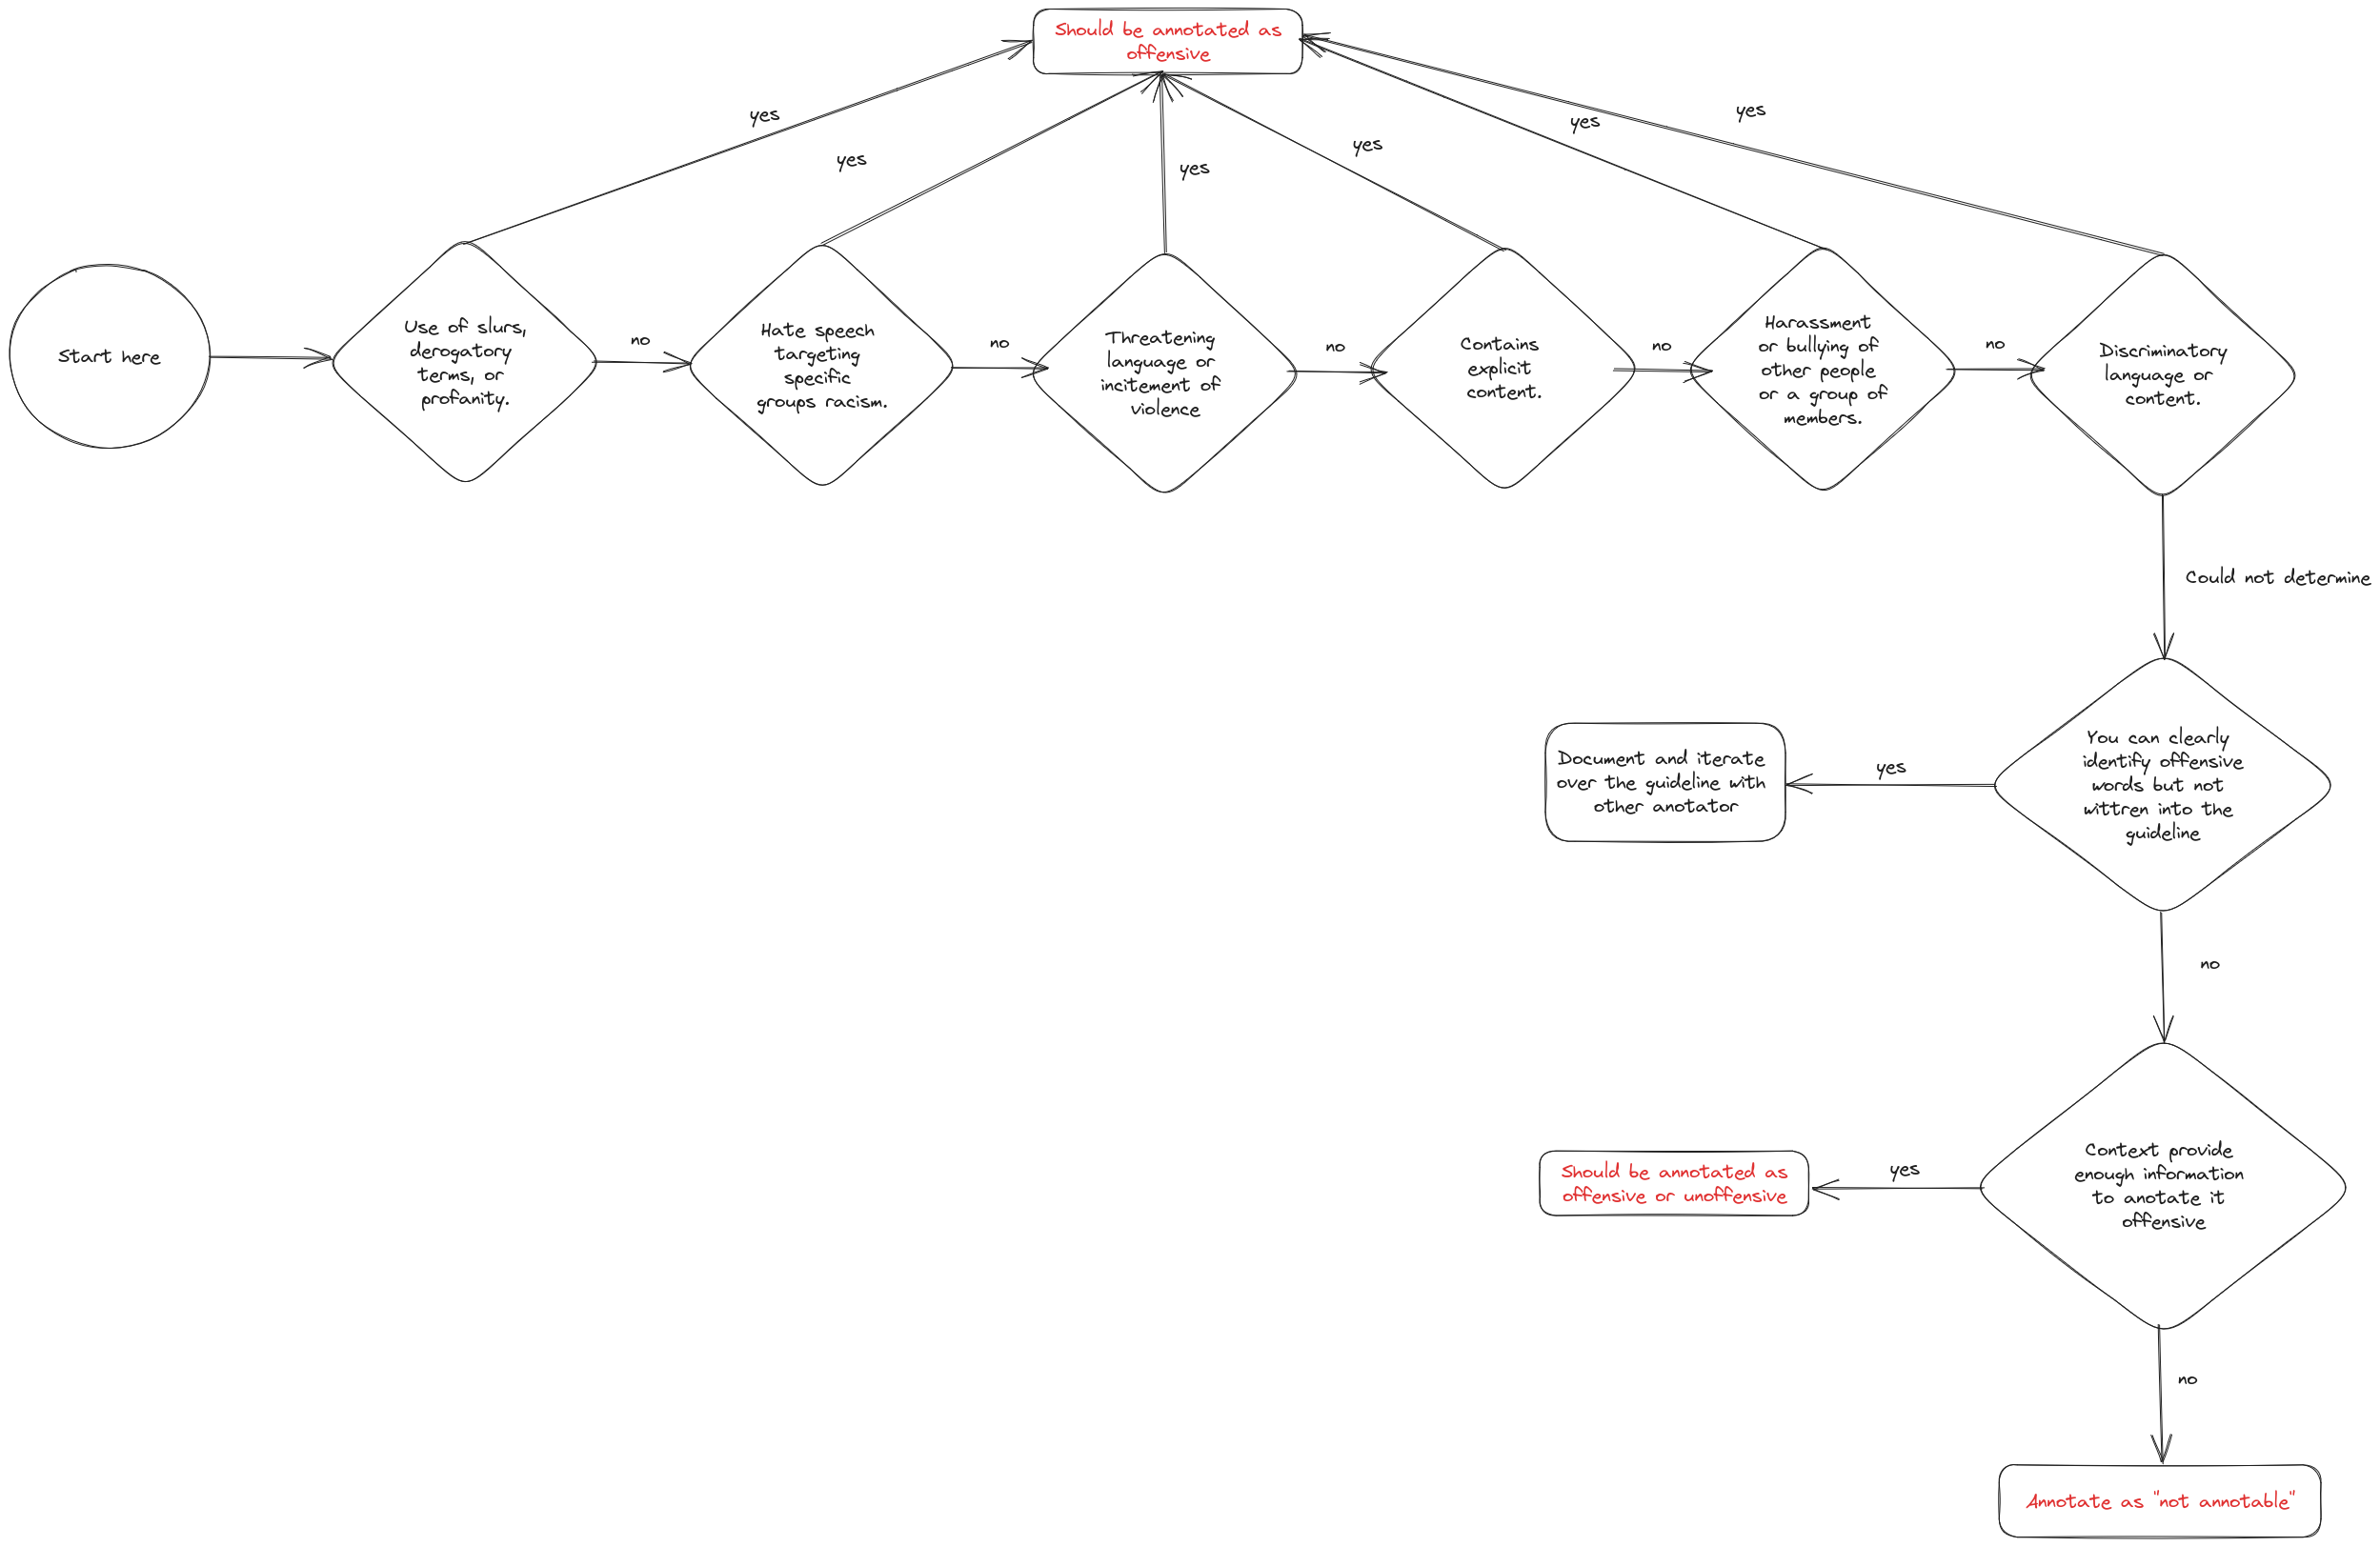

6. **Bonus** Evaluate the model your data. Use a majority vote for labels (remove majority "can't tell") and compute the precision, recall, and F1-score.

Please provide the annotation sheets, the guideline, and the inter-annotator agreement in your report.

We start by adding the mean of the label to the dataframe.

In [61]:
labels_df["label"] = labels_df[["Tom label", "Antoine label", "Bastien label"]].mean(axis=1).round()

In [81]:
label2int = lambda s: 1 if s == 'offensive' else 0
tweets_preds["label"] = tweets_preds["label"].apply(label2int)
print(classification_report(labels_df["label"], tweets_preds["label"]))

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88        92
         1.0       0.27      0.88      0.41         8

    accuracy                           0.80       100
   macro avg       0.63      0.83      0.65       100
weighted avg       0.93      0.80      0.84       100



We achieve a good F1 score, precision, and recall with annotation. It appears that your annotation approach is similar to how the original dataset was annotated.

## Evaluation

**This lab is mainly about data and model analysis. There is very little code. Make sure you send back a proper report with your code, guideline, annotated sheets, and theoretical answers.**

The assignment will be evaluated on the following criteria.
* A report answering the questions above, describing your technical choices, and analysing your results.
* The quality of your code (modularity, efficiency, comments, coding standards).

For coding standards, please respect the following guidelines
* Use [docstring](https://www.programiz.com/python-programming/docstrings) format to describe your functions and their arguments
* Use typing
* Have clear and verbatim variable names (not x, x1, x2, xx, another_x, ...)
* Make your results reproducible (force random seeds values)
* Don't hesitate commenting in details part of the code you consider complex or hard to read

Provide a `README.md` file with
* A short description of the project
* A description of the file/module architecture

This part has to be sent back to `marc.von-wyl` at `epita` dot `fr` before **Thursday 22nd of June 2023 at 10pm**.